In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision.utils as vutils
import torch.utils.data as data

import matplotlib.pyplot as plt
import os
import numpy as np
import time

import torchvision

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Device is", device)
# !nvidia-smi

# Displaying function
def imshow(img,size=None):
    img = img*0.5 + 0.5     # unnormalize
    if size is not None:
        img = transforms.Resize(size=size, interpolation=transforms.InterpolationMode.NEAREST, antialias=True)(img)
    pil_img = torchvision.transforms.functional.to_pil_image(img)
    display(pil_img)
    # print("Image size (h x w): ",  pil_img.height, "x", pil_img.width)
    return None

Device is cuda:1


In [54]:
batch_size=128
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_set = MNIST(os.getcwd(), train=True, transform=transform, download=True)
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

torch.Size([128, 1, 28, 28])


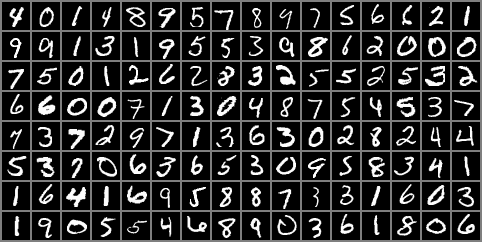

In [55]:
real,_ = next(iter(train_loader))
print(real.shape)

pil_img = imshow(torchvision.utils.make_grid(real.to(device),nrow=16))

In [56]:
# Size  of generator input
nz = 100

# Size of feature maps in generator and discriminator
ngf, ndf = 64, 64

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels = ngf, out_channels = 1, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
            # output size. 1 x 28 x 28
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is 1 x 28 x 28
            nn.Conv2d(in_channels = 1, out_channels = ndf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 15 x 15
            nn.Conv2d(in_channels = ndf, out_channels= ndf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(in_channels = ndf * 2, out_channels = ndf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 5 x 5
            nn.Conv2d(in_channels = ndf * 4, out_channels = 1, kernel_size = 4, stride = 2, padding = 1, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# check sizes:
# import torchsummary

# # Create some generator and discriminator
# netG = Generator().to(device)
# netD = Discriminator().to(device)

# torchsummary.summary(netG, input_size=(nz,1,1))
# torchsummary.summary(netD, input_size=(1,28,28))


In [57]:
# function to display samples of the generator
def show(G,z=None,batch_size=128,nz=100,device = device):
  # provide random latent code as option to see evolution
  with torch.no_grad():
    if z==None:
      z = torch.randn(batch_size,nz,1,1).to(device)
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to(device),nrow=16))
    return(pil_img)

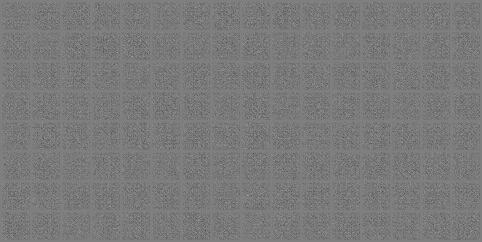

In [58]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and discriminator
G = Generator().to(device)
D = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
G.apply(weights_init);
D.apply(weights_init);

show(G);

In [59]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )

    def forward(self, img):
        features = self.model(img)
        return features

## MMD GAN

In [60]:
def MMD(x, y):
    """Emprical maximum mean discrepancy. The lower the result, the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    x = x.view(x.size(0), -1)  # [batch_size, features]
    y = y.view(y.size(0), -1)  # [batch_size, features]

    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    """
    print(rx.t().shape)
    print(ry.shape)
    print(zz.shape)
    """
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))


    #rbf kernel
    bandwidth_range = [10, 15, 20, 50]
    for a in bandwidth_range:
      XX += torch.exp(-0.5*dxx/a)
      YY += torch.exp(-0.5*dyy/a)
      XY += torch.exp(-0.5*dxy/a)

    return torch.mean(XX + YY - 2. * XY)

## Gradient Penalty 

In [61]:

def gradient_penalty(D, x, y):
    b = x.shape[0]
    n = y.shape[0]
    # shrink vectors if they are too large
    if n > b:
        y = y[0:b, :, :, :]
        n = b
    else:
        x = x[0:n, :, :, :]
        b = n
    # compute interpolated points
    alpha = torch.rand((b, 1, 1, 1), device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
                                    create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients = gradients.view(b, -1)
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)  # Add epsilon to avoid numerical instability

    # Return gradient penalty
    return ((gradients_norm - 1) ** 2).mean()

## TRAIN MMD-DCGAN

sur gpu

In [62]:
# MODIFIED MMD GAN
torch.manual_seed(1)  # initialize random seed for reproducibility
from tqdm import tqdm

log_every = 200
gpw = 0.05

G = Generator().to(device)
D = Discriminator().to(device)
feature_extractor = FeatureExtractor().to(device)
G.apply(weights_init);
D.apply(weights_init);

optimD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

zviz = torch.randn(batch_size,nz,1,1).to(device)

In [63]:
gpw = 0.07
num_epochs = 50
#sorry for the bad code, I am in a hurry
losses = []
t0 = time.time()
for epoch in range(num_epochs):
    # For each batch in the train_loader
    for i, batch in enumerate(tqdm(train_loader, 0), 0):

        real = batch[0].to(device)
        
        optimG.zero_grad()

        fake = G(torch.randn(batch_size, nz, 1, 1, device=device))
        faked = fake.detach()
        output = D(fake)
        print("out put shape ", output.shape)
        print("fake shape ", fake.shape)
    
        break;
        gp = gradient_penalty(D,real,fake)
       
        mmd_loss = MMD(real.view(real.size(0), -1), output.view(output.size(0), -1))        #Gloss = torch.mean(MMD(real,fake)) + gpw*gp
        Gloss = mmd_loss + gpw*gp

        
        Gloss.backward(retain_graph=True)
        optimG.step()

        if i % log_every == 0:
            print('[%d/%d][%d/%d][%.4f s]\tLoss_G: %.4f\t'
                  % (epoch+1, num_epochs, i, len(train_loader), time.time()-t0, Gloss.item()))
            losses.append(Gloss.item())
    
    
print('Total learning time = ',time.time()-t0)




  1%|          | 3/468 [00:04<08:38,  1.11s/it]

[1/50][0/468][4.1456 s]	Loss_G: 3.5008	


 44%|████▎     | 204/468 [00:16<00:16, 16.34it/s]

[1/50][200/468][16.7541 s]	Loss_G: 0.1071	


 86%|████████▌ | 403/468 [00:28<00:03, 17.44it/s]

[1/50][400/468][28.7520 s]	Loss_G: 0.0960	


  0%|          | 2/468 [00:05<16:48,  2.16s/it]

[2/50][0/468][38.6503 s]	Loss_G: 0.0983	


 43%|████▎     | 203/468 [00:18<00:18, 14.39it/s]

[2/50][200/468][51.8696 s]	Loss_G: 0.0993	


 86%|████████▋ | 404/468 [00:30<00:03, 16.00it/s]

[2/50][400/468][64.3633 s]	Loss_G: 0.0945	


  1%|          | 3/468 [00:03<07:13,  1.07it/s]

[3/50][0/468][72.4549 s]	Loss_G: 0.0995	


 44%|████▎     | 204/468 [00:16<00:15, 16.73it/s]

[3/50][200/468][85.0631 s]	Loss_G: 0.0994	


 86%|████████▌ | 402/468 [00:28<00:03, 16.54it/s]

[3/50][400/468][97.6689 s]	Loss_G: 0.0947	


  1%|          | 3/468 [00:05<10:19,  1.33s/it]

[4/50][0/468][107.3439 s]	Loss_G: 0.1007	


 44%|████▎     | 204/468 [00:18<00:17, 15.13it/s]

[4/50][200/468][120.9483 s]	Loss_G: 0.0952	


 86%|████████▋ | 404/468 [00:32<00:04, 15.01it/s]

[4/50][400/468][134.3561 s]	Loss_G: 0.0897	


  0%|          | 2/468 [00:04<14:32,  1.87s/it]

[5/50][0/468][143.6502 s]	Loss_G: 0.0948	


 44%|████▎     | 204/468 [00:17<00:16, 16.13it/s]

[5/50][200/468][156.2523 s]	Loss_G: 0.0921	


 86%|████████▋ | 404/468 [00:29<00:03, 16.32it/s]

[5/50][400/468][168.5558 s]	Loss_G: 0.0953	


  1%|          | 3/468 [00:05<10:23,  1.34s/it]

[6/50][0/468][178.1492 s]	Loss_G: 0.0989	


 43%|████▎     | 203/468 [00:18<00:17, 14.74it/s]

[6/50][200/468][191.4484 s]	Loss_G: 0.0939	


 86%|████████▋ | 404/468 [00:31<00:03, 17.82it/s]

[6/50][400/468][204.3448 s]	Loss_G: 0.0871	


  0%|          | 1/468 [00:03<31:04,  3.99s/it]

[7/50][0/468][212.8617 s]	Loss_G: 0.0935	


 44%|████▎     | 204/468 [00:16<00:15, 16.85it/s]

[7/50][200/468][225.3619 s]	Loss_G: 0.0906	


 86%|████████▋ | 404/468 [00:28<00:03, 16.33it/s]

[7/50][400/468][237.5547 s]	Loss_G: 0.0926	


  0%|          | 2/468 [00:04<14:49,  1.91s/it]

[8/50][0/468][246.6468 s]	Loss_G: 0.0955	


 43%|████▎     | 203/468 [00:17<00:17, 14.90it/s]

[8/50][200/468][259.7686 s]	Loss_G: 0.0879	


 86%|████████▋ | 404/468 [00:30<00:04, 15.06it/s]

[8/50][400/468][272.1546 s]	Loss_G: 0.0911	


  1%|          | 3/468 [00:04<08:30,  1.10s/it]

[9/50][0/468][280.9521 s]	Loss_G: 0.0933	


 44%|████▎     | 204/468 [00:16<00:17, 14.68it/s]

[9/50][200/468][293.5480 s]	Loss_G: 0.0883	


 86%|████████▋ | 404/468 [00:29<00:04, 15.09it/s]

[9/50][400/468][305.9508 s]	Loss_G: 0.0691	


  1%|          | 3/468 [00:04<09:59,  1.29s/it]

[10/50][0/468][315.4480 s]	Loss_G: 0.0687	


 44%|████▎     | 204/468 [00:18<00:15, 16.66it/s]

[10/50][200/468][328.4679 s]	Loss_G: 0.0653	


 86%|████████▋ | 404/468 [00:30<00:03, 16.55it/s]

[10/50][400/468][340.7631 s]	Loss_G: 0.0696	


  1%|          | 3/468 [00:04<08:23,  1.08s/it]

[11/50][0/468][349.6476 s]	Loss_G: 0.0682	


 44%|████▎     | 204/468 [00:16<00:18, 14.29it/s]

[11/50][200/468][362.0450 s]	Loss_G: 0.0653	


 86%|████████▋ | 404/468 [00:28<00:03, 17.30it/s]

[11/50][400/468][373.9589 s]	Loss_G: 0.0651	


  1%|          | 3/468 [00:05<11:09,  1.44s/it]

[12/50][0/468][384.2646 s]	Loss_G: 0.0640	


 44%|████▎     | 204/468 [00:17<00:16, 16.40it/s]

[12/50][200/468][396.6672 s]	Loss_G: 0.0668	


 86%|████████▋ | 404/468 [00:29<00:04, 16.00it/s]

[12/50][400/468][408.7473 s]	Loss_G: 0.0639	


  1%|          | 3/468 [00:05<10:09,  1.31s/it]

[13/50][0/468][418.2432 s]	Loss_G: 0.0643	


 43%|████▎     | 203/468 [00:17<00:15, 17.43it/s]

[13/50][200/468][430.2489 s]	Loss_G: 0.0633	


 86%|████████▋ | 404/468 [00:29<00:03, 16.31it/s]

[13/50][400/468][442.3541 s]	Loss_G: 0.0654	


  0%|          | 2/468 [00:04<14:49,  1.91s/it]

[14/50][0/468][451.3469 s]	Loss_G: 0.0656	


 43%|████▎     | 203/468 [00:17<00:16, 15.90it/s]

[14/50][200/468][463.9689 s]	Loss_G: 0.0653	


 86%|████████▋ | 404/468 [00:29<00:03, 17.23it/s]

[14/50][400/468][476.0687 s]	Loss_G: 0.0640	


  1%|          | 3/468 [00:05<10:49,  1.40s/it]

[15/50][0/468][485.7490 s]	Loss_G: 0.0635	


 44%|████▎     | 204/468 [00:17<00:16, 16.16it/s]

[15/50][200/468][498.0521 s]	Loss_G: 0.0642	


 86%|████████▋ | 404/468 [00:29<00:03, 16.69it/s]

[15/50][400/468][510.1676 s]	Loss_G: 0.0633	


  1%|          | 3/468 [00:04<09:45,  1.26s/it]

[16/50][0/468][519.4424 s]	Loss_G: 0.0643	


 44%|████▎     | 204/468 [00:17<00:15, 17.34it/s]

[16/50][200/468][532.1685 s]	Loss_G: 0.0633	


 86%|████████▋ | 404/468 [00:29<00:03, 16.25it/s]

[16/50][400/468][544.2542 s]	Loss_G: 0.0624	


  0%|          | 2/468 [00:05<16:44,  2.16s/it]

[17/50][0/468][553.9474 s]	Loss_G: 0.0650	


 44%|████▎     | 204/468 [00:17<00:15, 16.84it/s]

[17/50][200/468][566.4618 s]	Loss_G: 0.0626	


 86%|████████▌ | 403/468 [00:30<00:04, 16.03it/s]

[17/50][400/468][579.1688 s]	Loss_G: 0.0631	


  1%|          | 3/468 [00:05<10:48,  1.40s/it]

[18/50][0/468][588.8507 s]	Loss_G: 0.0638	


 44%|████▎     | 204/468 [00:17<00:16, 16.00it/s]

[18/50][200/468][601.5482 s]	Loss_G: 0.0646	


 86%|████████▋ | 404/468 [00:29<00:04, 15.65it/s]

[18/50][400/468][613.5541 s]	Loss_G: 0.0638	


  1%|          | 3/468 [00:04<10:11,  1.32s/it]

[19/50][0/468][622.9488 s]	Loss_G: 0.0623	


 44%|████▎     | 204/468 [00:17<00:15, 16.56it/s]

[19/50][200/468][635.1627 s]	Loss_G: 0.0609	


 86%|████████▋ | 404/468 [00:29<00:03, 17.14it/s]

[19/50][400/468][647.1688 s]	Loss_G: 0.0624	


  1%|          | 3/468 [00:04<08:32,  1.10s/it]

[20/50][0/468][655.6520 s]	Loss_G: 0.0624	


 43%|████▎     | 203/468 [00:17<00:15, 16.79it/s]

[20/50][200/468][668.7480 s]	Loss_G: 0.0661	


 86%|████████▋ | 404/468 [00:29<00:03, 16.29it/s]

[20/50][400/468][681.0675 s]	Loss_G: 0.0619	


  1%|          | 3/468 [00:04<08:34,  1.11s/it]

[21/50][0/468][689.9464 s]	Loss_G: 0.0633	


 44%|████▎     | 204/468 [00:16<00:16, 15.70it/s]

[21/50][200/468][702.3545 s]	Loss_G: 0.0630	


 86%|████████▋ | 404/468 [00:28<00:03, 17.07it/s]

[21/50][400/468][714.4704 s]	Loss_G: 0.0631	


  1%|          | 3/468 [00:05<10:21,  1.34s/it]

[22/50][0/468][723.9495 s]	Loss_G: 0.0624	


 44%|████▎     | 204/468 [00:17<00:16, 15.65it/s]

[22/50][200/468][736.7481 s]	Loss_G: 0.0629	


 86%|████████▋ | 404/468 [00:30<00:04, 14.95it/s]

[22/50][400/468][748.9473 s]	Loss_G: 0.0631	


  0%|          | 2/468 [00:04<15:48,  2.03s/it]

[23/50][0/468][758.2637 s]	Loss_G: 0.0638	


 43%|████▎     | 203/468 [00:17<00:17, 14.79it/s]

[23/50][200/468][770.6633 s]	Loss_G: 0.0646	


 86%|████████▋ | 404/468 [00:29<00:04, 15.82it/s]

[23/50][400/468][782.9547 s]	Loss_G: 0.0628	


  0%|          | 1/468 [00:04<38:45,  4.98s/it]

[24/50][0/468][792.7431 s]	Loss_G: 0.0658	


 44%|████▎     | 204/468 [00:17<00:15, 16.57it/s]

[24/50][200/468][805.1679 s]	Loss_G: 0.0626	


 86%|████████▌ | 402/468 [00:29<00:03, 16.96it/s]

[24/50][400/468][817.2694 s]	Loss_G: 0.0627	


  1%|          | 3/468 [00:04<08:59,  1.16s/it]

[25/50][0/468][826.0476 s]	Loss_G: 0.0634	


 44%|████▎     | 204/468 [00:16<00:16, 16.25it/s]

[25/50][200/468][838.6547 s]	Loss_G: 0.0619	


 86%|████████▋ | 404/468 [00:29<00:03, 16.37it/s]

[25/50][400/468][850.9547 s]	Loss_G: 0.0632	


  0%|          | 2/468 [00:04<14:30,  1.87s/it]

[26/50][0/468][859.9481 s]	Loss_G: 0.0640	


 43%|████▎     | 203/468 [00:17<00:16, 15.72it/s]

[26/50][200/468][872.5694 s]	Loss_G: 0.0630	


 86%|████████▌ | 403/468 [00:29<00:04, 14.84it/s]

[26/50][400/468][884.8687 s]	Loss_G: 0.0634	


  1%|          | 3/468 [00:05<10:10,  1.31s/it]

[27/50][0/468][894.4621 s]	Loss_G: 0.0623	


 43%|████▎     | 203/468 [00:17<00:16, 16.10it/s]

[27/50][200/468][907.0548 s]	Loss_G: 0.0626	


 86%|████████▋ | 404/468 [00:29<00:03, 16.43it/s]

[27/50][400/468][919.3547 s]	Loss_G: 0.0632	


  1%|          | 3/468 [00:05<10:44,  1.39s/it]

[28/50][0/468][929.6610 s]	Loss_G: 0.0620	


 44%|████▎     | 204/468 [00:18<00:15, 17.10it/s]

[28/50][200/468][942.3697 s]	Loss_G: 0.0627	


 86%|████████▋ | 404/468 [00:29<00:03, 16.20it/s]

[28/50][400/468][954.3472 s]	Loss_G: 0.0621	


  1%|          | 3/468 [00:04<09:34,  1.24s/it]

[29/50][0/468][963.3475 s]	Loss_G: 0.0637	


 43%|████▎     | 203/468 [00:16<00:16, 16.28it/s]

[29/50][200/468][975.6421 s]	Loss_G: 0.0615	


 86%|████████▌ | 403/468 [00:28<00:04, 15.60it/s]

[29/50][400/468][987.6682 s]	Loss_G: 0.0628	


  1%|          | 3/468 [00:04<10:07,  1.31s/it]

[30/50][0/468][997.3512 s]	Loss_G: 0.0632	


 44%|████▎     | 204/468 [00:17<00:15, 16.96it/s]

[30/50][200/468][1010.2688 s]	Loss_G: 0.0630	


 86%|████████▋ | 404/468 [00:29<00:04, 15.99it/s]

[30/50][400/468][1022.3547 s]	Loss_G: 0.0637	


  0%|          | 1/468 [00:04<33:30,  4.31s/it]

[31/50][0/468][1031.2496 s]	Loss_G: 0.0613	


 44%|████▎     | 204/468 [00:17<00:15, 16.61it/s]

[31/50][200/468][1044.6703 s]	Loss_G: 0.0631	


 86%|████████▋ | 404/468 [00:30<00:04, 15.30it/s]

[31/50][400/468][1057.2473 s]	Loss_G: 0.0630	


  1%|          | 3/468 [00:05<10:22,  1.34s/it]

[32/50][0/468][1067.0520 s]	Loss_G: 0.0631	


 44%|████▎     | 204/468 [00:18<00:17, 14.69it/s]

[32/50][200/468][1080.4431 s]	Loss_G: 0.0631	


 86%|████████▋ | 404/468 [00:31<00:04, 15.22it/s]

[32/50][400/468][1093.0477 s]	Loss_G: 0.0622	


  0%|          | 2/468 [00:04<15:09,  1.95s/it]

[33/50][0/468][1102.1647 s]	Loss_G: 0.0631	


 44%|████▎     | 204/468 [00:18<00:20, 13.08it/s]

[33/50][200/468][1116.0497 s]	Loss_G: 0.0630	


 86%|████████▌ | 403/468 [00:38<00:04, 14.74it/s]

[33/50][400/468][1136.1422 s]	Loss_G: 0.0630	


  0%|          | 1/468 [00:04<38:51,  4.99s/it]

[34/50][0/468][1147.9446 s]	Loss_G: 0.0645	


 43%|████▎     | 203/468 [00:21<00:17, 15.00it/s]

[34/50][200/468][1164.3466 s]	Loss_G: 0.0640	


 86%|████████▌ | 402/468 [00:34<00:03, 16.56it/s]

[34/50][400/468][1176.9432 s]	Loss_G: 0.0618	


  1%|          | 3/468 [00:04<08:56,  1.15s/it]

[35/50][0/468][1185.7515 s]	Loss_G: 0.0625	


 44%|████▎     | 204/468 [00:17<00:17, 15.16it/s]

[35/50][200/468][1198.7477 s]	Loss_G: 0.0619	


 86%|████████▋ | 404/468 [00:29<00:03, 17.45it/s]

[35/50][400/468][1210.9442 s]	Loss_G: 0.0615	


  0%|          | 2/468 [00:04<13:31,  1.74s/it]

[36/50][0/468][1219.5413 s]	Loss_G: 0.0615	


 43%|████▎     | 203/468 [00:17<00:17, 14.82it/s]

[36/50][200/468][1232.3638 s]	Loss_G: 0.0634	


 86%|████████▋ | 404/468 [00:31<00:04, 15.33it/s]

[36/50][400/468][1247.2492 s]	Loss_G: 0.0621	


  1%|          | 3/468 [00:04<09:08,  1.18s/it]

[37/50][0/468][1256.6506 s]	Loss_G: 0.0632	


 44%|████▎     | 204/468 [00:17<00:15, 17.50it/s]

[37/50][200/468][1269.2696 s]	Loss_G: 0.0647	


 87%|████████▋ | 405/468 [00:29<00:03, 16.61it/s]

[37/50][400/468][1281.7478 s]	Loss_G: 0.0636	


  1%|          | 3/468 [00:04<09:11,  1.19s/it]

[38/50][0/468][1290.9460 s]	Loss_G: 0.0605	


 43%|████▎     | 203/468 [00:17<00:18, 14.25it/s]

[38/50][200/468][1304.1653 s]	Loss_G: 0.0608	


 86%|████████▋ | 404/468 [00:30<00:04, 14.42it/s]

[38/50][400/468][1316.7456 s]	Loss_G: 0.0611	


  0%|          | 1/468 [00:04<33:30,  4.30s/it]

[39/50][0/468][1325.6552 s]	Loss_G: 0.0625	


 44%|████▎     | 204/468 [00:17<00:16, 16.05it/s]

[39/50][200/468][1338.3681 s]	Loss_G: 0.0617	


 86%|████████▌ | 403/468 [00:30<00:03, 16.36it/s]

[39/50][400/468][1351.9484 s]	Loss_G: 0.0643	


  1%|          | 3/468 [00:04<09:21,  1.21s/it]

[40/50][0/468][1361.0582 s]	Loss_G: 0.0618	


 43%|████▎     | 203/468 [00:18<00:17, 14.74it/s]

[40/50][200/468][1374.6726 s]	Loss_G: 0.0625	


 86%|████████▌ | 403/468 [00:31<00:04, 15.85it/s]

[40/50][400/468][1387.5684 s]	Loss_G: 0.0627	


  0%|          | 2/468 [00:03<11:36,  1.49s/it]

[41/50][0/468][1396.0635 s]	Loss_G: 0.0623	


 43%|████▎     | 202/468 [00:16<00:16, 16.21it/s]

[41/50][200/468][1409.0690 s]	Loss_G: 0.0670	


 86%|████████▋ | 404/468 [00:30<00:04, 14.90it/s]

[41/50][400/468][1422.6466 s]	Loss_G: 0.0643	


  0%|          | 1/468 [00:05<40:26,  5.20s/it]

[42/50][0/468][1432.8443 s]	Loss_G: 0.0624	


 44%|████▎     | 204/468 [00:19<00:15, 16.97it/s]

[42/50][200/468][1446.5765 s]	Loss_G: 0.0628	


 86%|████████▋ | 404/468 [00:33<00:04, 14.91it/s]

[42/50][400/468][1460.8495 s]	Loss_G: 0.0637	


  1%|          | 3/468 [00:05<10:23,  1.34s/it]

[43/50][0/468][1470.5451 s]	Loss_G: 0.0620	


 44%|████▎     | 204/468 [00:17<00:15, 17.32it/s]

[43/50][200/468][1483.3435 s]	Loss_G: 0.0646	


 86%|████████▋ | 404/468 [00:30<00:04, 14.94it/s]

[43/50][400/468][1495.5545 s]	Loss_G: 0.0623	


  1%|          | 3/468 [00:04<09:33,  1.23s/it]

[44/50][0/468][1504.9619 s]	Loss_G: 0.0621	


 43%|████▎     | 203/468 [00:17<00:17, 15.05it/s]

[44/50][200/468][1517.4695 s]	Loss_G: 0.0622	


 86%|████████▌ | 403/468 [00:29<00:04, 14.99it/s]

[44/50][400/468][1530.0685 s]	Loss_G: 0.0606	


  1%|          | 3/468 [00:04<08:56,  1.15s/it]

[45/50][0/468][1539.0600 s]	Loss_G: 0.0657	


 44%|████▎     | 204/468 [00:18<00:18, 14.06it/s]

[45/50][200/468][1552.7448 s]	Loss_G: 0.0621	


 86%|████████▌ | 403/468 [00:30<00:04, 15.72it/s]

[45/50][400/468][1565.5709 s]	Loss_G: 0.0618	


  1%|          | 3/468 [00:04<08:22,  1.08s/it]

[46/50][0/468][1574.0508 s]	Loss_G: 0.0627	


 44%|████▎     | 204/468 [00:16<00:17, 15.27it/s]

[46/50][200/468][1586.6550 s]	Loss_G: 0.0631	


 86%|████████▋ | 404/468 [00:29<00:03, 16.46it/s]

[46/50][400/468][1598.9703 s]	Loss_G: 0.0611	


  1%|          | 3/468 [00:03<07:22,  1.05it/s]

[47/50][0/468][1607.0598 s]	Loss_G: 0.0608	


 44%|████▎     | 204/468 [00:16<00:18, 14.27it/s]

[47/50][200/468][1620.3472 s]	Loss_G: 0.0616	


 86%|████████▌ | 403/468 [00:29<00:04, 15.88it/s]

[47/50][400/468][1632.8691 s]	Loss_G: 0.0610	


  1%|          | 3/468 [00:05<11:37,  1.50s/it]

[48/50][0/468][1643.2511 s]	Loss_G: 0.0611	


 43%|████▎     | 203/468 [00:18<00:16, 16.15it/s]

[48/50][200/468][1655.8687 s]	Loss_G: 0.0629	


 86%|████████▋ | 404/468 [00:30<00:03, 16.80it/s]

[48/50][400/468][1668.3697 s]	Loss_G: 0.0652	


  1%|          | 3/468 [00:04<09:41,  1.25s/it]

[49/50][0/468][1677.6522 s]	Loss_G: 0.0635	


 44%|████▎     | 204/468 [00:17<00:16, 16.23it/s]

[49/50][200/468][1690.6637 s]	Loss_G: 0.0605	


 86%|████████▌ | 403/468 [00:30<00:03, 17.27it/s]

[49/50][400/468][1703.0555 s]	Loss_G: 0.0639	


  1%|          | 3/468 [00:04<09:48,  1.27s/it]

[50/50][0/468][1712.3502 s]	Loss_G: 0.0626	


 44%|████▎     | 204/468 [00:18<00:18, 14.32it/s]

[50/50][200/468][1726.4474 s]	Loss_G: 0.0632	


 86%|████████▋ | 404/468 [00:31<00:04, 15.10it/s]

[50/50][400/468][1738.8473 s]	Loss_G: 0.0657	


100%|██████████| 468/468 [00:35<00:00, 13.10it/s]

Total learning time =  1743.460895061493


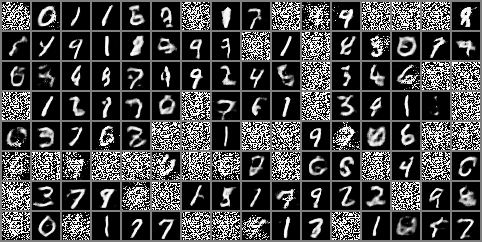

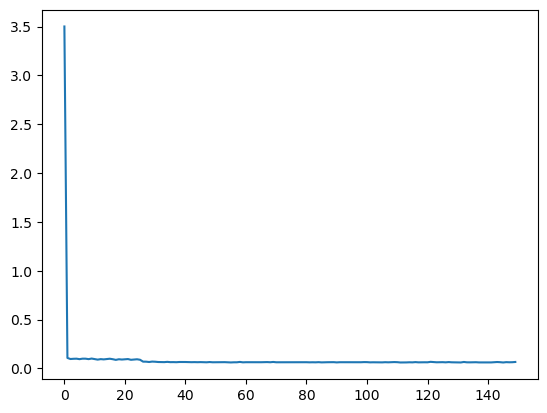

In [64]:
show(G,zviz,device = device)
plt.plot(losses)
plt.show()


35 epochs \
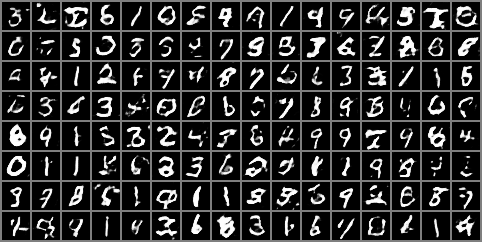

45 epochs\
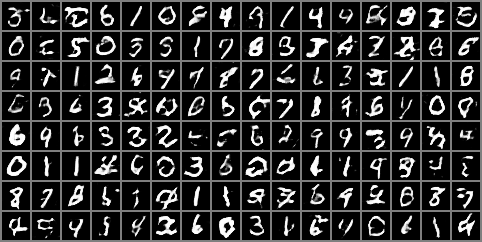

50 epochs\
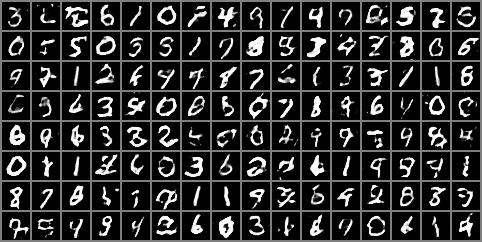

5 epochs with GP\
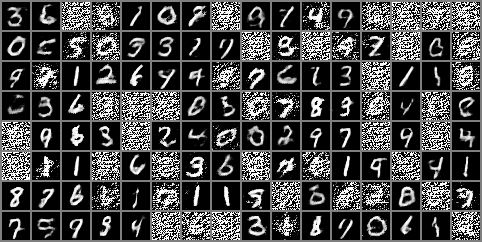
6
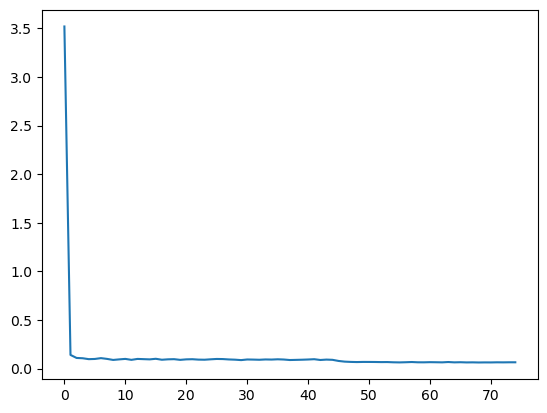

15 epochs with gradient penalty 0.1\

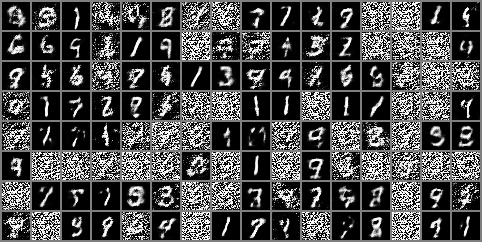\


948.7362341880798\


GP 0.05  \

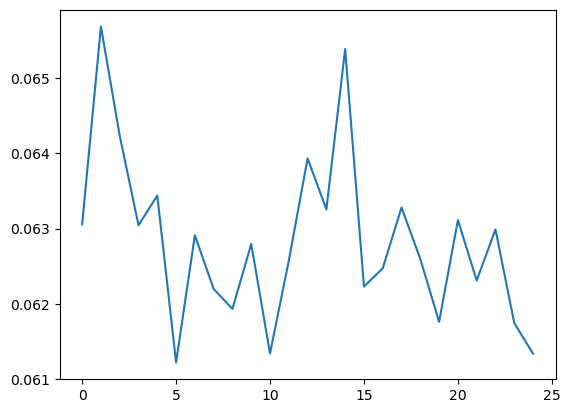\
Numbers are way cleaner with the gradient penalty \

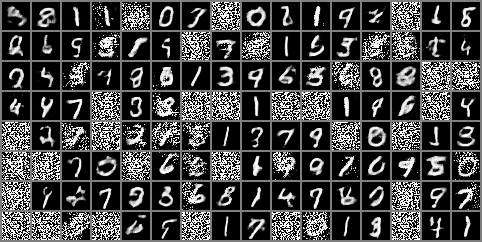


50 epochs with gradient penalty 0.07\
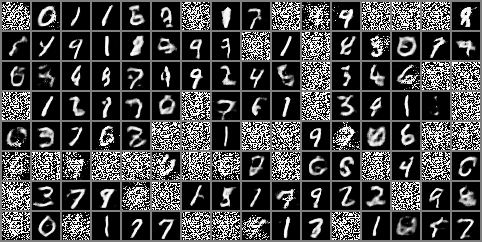




In [65]:
torch.save(G.state_dict(), 'model_weights/generator50epochsGP.pth')
torch.save(D.state_dict(), 'model_weights/discriminator50epochsgp.pth')

## Gradien penalty 

In [ ]:

def gradient_penalty(D, x, y):
    b = x.shape[0]
    n = y.shape[0]
    # shrink vectors if they are too large
    if n > b:
        y = y[0:b, :, :, :]
        n = b
    else:
        x = x[0:n, :, :, :]
        b = n
    # compute interpolated points
    alpha = torch.rand((b, 1, 1, 1), device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
                                    create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients = gradients.view(b, -1)
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)  # Add epsilon to avoid numerical instability

    # Return gradient penalty
    return ((gradients_norm - 1) ** 2).mean()

TODO : Trying to back on the mmd

In [ ]:
num_epochs = 10

t0 = time.time()
for epoch in range(num_epochs):
    # For each batch in the train_loader
    for i, batch in enumerate(tqdm(train_loader, 0), 0):

        ############################
        # Batchs of real and fake images
        real = batch[0].to(device)
        fake = G(torch.randn(batch_size, nz, 1, 1, device=device))
        faked = fake.detach()

        ############################
        # Update G network
        ### ... ###
        optimG.zero_grad()

        fake = G(torch.randn(batch_size, nz, 1, 1, device=device))
        output = D(fake)

        Gloss = torch.mean(MMD(fake,real))
        Gloss.backward()
        optimG.step()

        ############################
        # Display training stats and visualize
        if i % log_every == 0:
            print('[%d/%d][%d/%d][%.4f s]\tLoss_G: %.4f\t'
                  % (epoch+1, num_epochs, i, len(train_loader), time.time()-t0, Gloss.item()))
        
        #show(G,zviz,device = device)

print('Total learning time = ',time.time()-t0)




In [ ]:
# Save final generator in a variable for later use
wgan = Generator()
wgan.load_state_dict(G.state_dict())